# Learn Gradient

* Training Data: 33 AF IDs with to bootstrap a gradient with. Final output is a distro of gradients. 
* template: your choice of neat or matrix std.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
import matplotlib.patches as patches

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import os
import json
import time
from io import StringIO
from datetime import datetime
import re
import math

from sklearn.linear_model import LinearRegression
from scipy import integrate
from scipy.signal import find_peaks

import sys
sys.path.append("/Users/dteng/Documents/bin/nmr_utils/")
from nmr_targeted_utils import *
from nmr_fitting_funcs import *


# Load Data

In [2]:
# ===== params =====
template_path = "/Users/dteng/Documents/zdata/nmr/nmr_std_data/indiv_std_lproline/lproline_ph3.csv"
path_samples = "/Users/dteng/Documents/zdata/nmr/J202208B_pro_survey/training_set_csvs/"
bs_grad_path = "/Users/dteng/Documents/nmr_targeted/mlgrad/results/bootstrap_results.csv"
matching_path = "/Users/dteng/Documents/zdata/nmr/nmr_std_data/lr_matching_coords/lproline_ph3_matching_regions.csv"

# diff mcoords for neat-pro-std or pro_std_03
if "pro_std_03" in template_path:
    multiplets_ls = [[1.9,2.15], [2.304, 2.408],[3.25, 3.5],[4.1, 4.2]]
if "lproline_ph3" in template_path:
    multiplets_ls = [[1.9,2.15], [2.295, 2.403], [3.25, 3.5],[4.1, 4.2]]


normxcorr_th = 0.0 # set to this number to filter out multiplets which aren't at least normxcorr_th, i.e. poor fits
ref_pk_window = [-0.2, 0.2]
ref_pk_tolerance_window = [0,0]
search_region_padding_size = 0.02

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
folder_name = f"./results/mlgrad_fitting-{template_path.split('/')[-1].replace('.csv', '')}-{timestamp}"
fn_out_plot = "training_fit_viz.html"

print(f"results folder = {folder_name}")

# ========== load data ==========
# load STD template(s)
template_df = pd.read_csv(template_path)
template_df = adjust_to_ref_peak(template_df, ref_pk_window, ref_pk_tolerance_window)

# load sample (training) data - only QCs and Rs
df_dict = {}
for fn in os.listdir(path_samples):
    if ".csv" in fn:
        k = fn.split(".")[0].replace("_QC", "_Q")
        df_dict[k] = pd.read_csv(os.path.join(path_samples, fn))
print(f"Loaded {len(df_dict)} samples.")

matching_regions_ls = [
    [2.305, 2.306],
    [2.31, 2.316],
    [2.321, 2.3225],
    [2.331, 2.333],
    [2.337, 2.339],
    [2.342, 2.3445],
    [2.347, 2.349],
    [2.3585, 2.3605],
    [2.365, 2.3675],
    [2.3755, 2.3765],
    [2.381, 2.39]]

results folder = ./results/mlgrad_fitting-lproline_ph3-20240405_1617
Loaded 128 samples.


# Run

In [3]:
# ===== run 1d_std_search =====
results_dict = {}
for k in sorted(list(df_dict.keys())):
    target_df = df_dict[k]
    results_dict[k] = do_1d_std_search(
        query_df=template_df,
        target_df=target_df,
        multiplets_ls=multiplets_ls,
        search_region_padding_size=search_region_padding_size
    )

# get reds
red_dt = template_df.copy()
red_dt = red_dt.loc[(red_dt["ppm"]>min(multiplets_ls[1])) & (red_dt["ppm"]<max(multiplets_ls[1]))]

# get blues
blue_m1_dict = get_blue_m1_dict(results_dict, 
                                df_dict,
                                mcoords=multiplets_ls[1]
                               )

# ===== get corr_series_dict =====
# get corr_series for each k, stored in corr_series_dict
corr_series_dict = {}
for k in sorted(list(results_dict.keys())):
    dt = get_correlation_series(red_dt, 
                                blue_m1_dict[k].copy(),
                                min_corr=0, 
                                min_corr_replacement_value=0,
                                window_size_nrows=64,
                                exponent=8
                               )
    corr_series_dict[k] = dt

# ===== run LR matching =====
df_conc = get_df_conc_lrmatching(
    results_dict=results_dict, 
    template_df=template_df.copy(), 
    df_dict=df_dict, 
    mcoords=multiplets_ls[1],
    matching_coords_ls=matching_regions_ls,
    corr_series_dict=corr_series_dict
)


# Viz

In [4]:
# plot multiplet_1 only
t0 = time.time()

# ===== plot match results =====
fig, ax = plt.subplots(nrows=len(results_dict), # top row for LR results
                       ncols=1, 
                       figsize=(7, len(results_dict)*4)
                      )

red_dt = template_df.copy()
red_dt = red_dt.loc[(red_dt["ppm"]>min(multiplets_ls[1])) & (red_dt["ppm"]<max(multiplets_ls[1]))]

i = 0
for k in sorted(list(results_dict.keys())):
    # plot fit
    normxcorr = results_dict[k]["multiplet_1"]["max_rho"][0]
    ax[i].plot(blue_m1_dict[k].ppm.values, 
               blue_m1_dict[k].intensity.values, c="steelblue")

    m = df_conc.loc[df_conc["sample_name"]==k]["slope"].values[0]
    c = df_conc.loc[df_conc["sample_name"]==k]["intercept"].values[0]
    ax[i].plot(red_dt.ppm.values, 
               (red_dt.intensity.values*m)+c, 
               c="indianred")

    ax[i].set_title(f"{i+1}. {k}\nnormxcorr={round(normxcorr, 4)}", fontsize=20)
    
    # plot sliding window of correlation
    ax2 = ax[i].twinx()
    ax2.plot(corr_series_dict[k]["ppm"], 
             corr_series_dict[k]["corr_series"], 
             lw=0.7,
             c="k")
    
    # set bg colour
    transparency = 0.65
    bg_colour = (1, 159/255, 165/255, transparency) # red
    if normxcorr >= 0.85 and normxcorr < 0.9:
        bg_colour = (1, 184/255, 100/255, transparency) # orange
    if normxcorr >= 0.9 and normxcorr < 0.95:
        bg_colour = (1, 242/255, 100/255, transparency) # yellow     
    if normxcorr >= 0.95 and normxcorr < 0.99:
        bg_colour = (150/255, 1, 153/255, transparency) # green
    elif normxcorr >= 0.99:
        bg_colour = (140/255, 220/255, 1, transparency) # light blue
    ax[i].set_facecolor(bg_colour)
    plt.setp(ax[i].get_xticklabels(), fontsize=20)
    plt.setp(ax[i].get_yticklabels(), fontsize=20)
    
    # draw matching regions
    rect_height = ax[i].get_ylim()[1]
    for row in matching_regions_ls:
        # Create a rectangle patch
        rect = patches.Rectangle((min(row), 0), 
                                 max(row) - min(row), 
                                 rect_height, 
                                 edgecolor=None,
                                 facecolor='grey', 
                                 alpha=0.25)

        # Add the rectangle patch to the plot
        ax[i].add_patch(rect)

    i += 1

plt.subplots_adjust(hspace=0.2, wspace=0)
plt.tight_layout()

#plt.show()
print("Done in %.2fs" % (time.time() - t0))

i = StringIO()
fig.savefig(i, format="svg")
output_svg = i.getvalue().strip().split("\n")
svg_ls = resize_svg(output_svg, resize_coeff=0.65)

# ===== prep html report =====
# not written as a function because of the sheer number of inputs required
html_contents = ["<html><head></head><body>"]

html_contents.append("<ul>")
html_contents.append(f"<li>Report generated: {datetime.today().strftime('%d %b %y, %-I:%M%p')}</li>")
html_contents.append(f"<li>num_samples = {len(results_dict)}</li>")
html_contents.append(f"<li>template = {template_path.split('/')[-1]}</li>")
html_contents.append(f"<li>normxcorr threshold = {normxcorr_th}</li>")
html_contents.append(f"<li>ref peak window = {ref_pk_window}</li>")
html_contents.append(f"<li>ref peak tolerance window = {ref_pk_tolerance_window}</li>")
html_contents.append(f"<li>search region padding size (ppm) = {search_region_padding_size}</li>")
#html_contents.append(f"<li>Output csv = {fn_out_df}</li>")
html_contents.append("</ul>")

html_contents.append("<hr>")
for line in output_svg:
    html_contents.append(line)
html_contents.append("</body></html>")

# ===== write out everything =====
# make foldername
os.makedirs(folder_name, exist_ok=True)

with open(f"./{folder_name}/{fn_out_plot}", "w") as f:
    for line in html_contents:
        f.write(line)

plt.close()

print(f"Wrote out to:")
print(folder_name)
print(f"{fn_out_plot}")

Done in 11.06s
Wrote out to:
./results/mlgrad_fitting-lproline_ph3-20240405_1617
training_fit_viz.html


In [5]:
# ===== write out csv =====
# write out a formatted csv as input to bootstrapping.R
d0 = df_conc.copy()
af_id_q_ls = []
af_id_r_ls = []
for nm in d0["sample_name"].values:
    if ("_Q1" in nm) or ("_Q2" in nm):
        af_id_q_ls.append(nm)
        r_name = nm.replace("_Q1", "_R1").replace("_Q2", "_R2")
        af_id_r_ls.append(r_name)

d0_q = d0.loc[d0["sample_name"].isin(af_id_q_ls)].reset_index(drop=True)[['sample_name', 'auc']]
d0_r = d0.loc[d0["sample_name"].isin(af_id_r_ls)].reset_index(drop=True)[['sample_name', 'auc']]
d0_q.columns = ["sample_name_q", "auc_q"]
d0_r.columns = ["sample_name_r", "auc_r"]

dz = pd.concat([d0_q, d0_r], axis=1)

# write out
dz.to_csv(f"{folder_name}/df_conc_t.csv", index=False)
print("Wrote out df_conc_t.csv as a formatted input to bootstrapping.R")

Wrote out df_conc_t.csv as a formatted input to bootstrapping.R


# Estimate Distro of Gradient

* This needs to be run iteratively to get a rough idea of "start" and "end", for bootstrapping bounds. Production run occurs in a VM.
* Bootstrapping = "out of a population of size m, repeatedly take sample of size n with replacement."
* You can do a bootstrapping prod run in this notebook if you're willing to wait a few hours, or you can run `bootstrapping.R` in a cloud VM of your choice. 

In [6]:
d0 = df_conc.copy()

# get list of unique AF IDs
temp_ls = list(set([x.replace("_Q1", "").replace("_Q2", "").replace("_R1", "").replace("_R2", "") for x in d0["sample_name"].values]))

uq_af_id_ls = []
outliers_ls = ["AWAC105", "AF63412"] # manually exclude known outliers
for af_id in temp_ls:
    if af_id not in outliers_ls:
        uq_af_id_ls.append(af_id)

# Get name pairs for each AF ID
af_id_namepair_ls = []
af_id_q_ls = []
af_id_r_ls = []
for af_id in uq_af_id_ls:
    k = af_id+"_Q1"
    val = af_id+"_R1"
    af_id_namepair_ls.append([k, val])
    k = af_id+"_Q2"
    val = af_id+"_R2"
    af_id_namepair_ls.append([k, val])
    
    af_id_q_ls.append(af_id+"_Q1")
    af_id_q_ls.append(af_id+"_Q2")
    
    af_id_r_ls.append(af_id+"_R1")
    af_id_r_ls.append(af_id+"_R2")

af_id_namepair_ls = np.array(af_id_namepair_ls)
d0_q = d0.loc[d0["sample_name"].isin(af_id_q_ls)].copy()[["sample_name", "auc"]]
d0_r = d0.loc[d0["sample_name"].isin(af_id_r_ls)].copy()[["sample_name", "auc"]]
m_q = d0_q.values
m_r = d0_r.values

# sanity check: m_q and r_q must have the same Q and R AF_IDs in each row
# there will be no 'ERROR...' printout if all clear
for i in range(len(m_q)):
    afid_q = m_q[i][0].replace("_Q1", "").replace("_Q2", "")
    afid_r = m_r[i][0].replace("_R1", "").replace("_R2", "")
    if afid_q != afid_r:
        print(f"ERROR: AF IDs not the same in row {i}!")

In [10]:
t0 = time.perf_counter()

end = 1.3E-9
start = 1.26E-9
grad_ls = get_sf_range(
    start=start,
    end=end,
    iter_size=1E-15 #interval_width
)

# start at 10 or 100 to estimate time taken, increase if you feel like it
# best to increase until you see a nice bell-shape in the histogram below
num_bootstrap_samples = 5000

mse_ls_ls = []
best_grad_ls = []
for i in range(num_bootstrap_samples):
    bootstrap_idx_ls = np.random.choice(np.arange(len(af_id_namepair_ls)), 
                                    size=len(af_id_namepair_ls), 
                                    replace=True
                                   )
    bootstrap_samples_ls = af_id_namepair_ls[bootstrap_idx_ls]
    
    auc_q_ls = d0.loc[d0["sample_name"].isin(bootstrap_samples_ls[:, 0])]["auc"].values
    auc_r_ls = d0.loc[d0["sample_name"].isin(bootstrap_samples_ls[:, 1])]["auc"].values
    
    mse_ls = []
    for grad in grad_ls:
        # this is a matrix operation, maybe np.matmul faster?
        err_ls = (grad*auc_q_ls) - (grad*auc_r_ls) - 1115
        mse = np.sum(np.square(err_ls))
        mse_ls.append(mse)

    best_grad = grad_ls[np.argmin(mse_ls)]
    #mse_ls_ls.append(mse_ls)
    best_grad_ls.append(best_grad)

ave_best_grad = np.average(best_grad_ls)

print("Done in %.2fs" % (time.perf_counter() - t0))


Done in 1552.93s


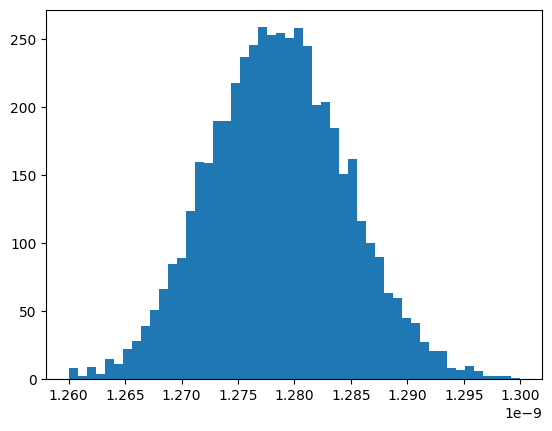

1.278552691e-09


In [11]:
# make sure that this histogram contains a maxima. 
# If it doesn't, it means that your choice of start and end need to be shifted.
plt.hist(best_grad_ls, bins=50)

plt.show()
print(np.average(best_grad_ls))

In [15]:
# save
dt = pd.DataFrame(data=best_grad_ls, columns=["grad_val"])
dt.to_csv("./results/bootstrap_results_n5000_5apr2024.csv", index=False)